<a href="https://colab.research.google.com/github/chi-hun/chi-hun/blob/main/datasetmake(image).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [281]:
import tensorflow as tf
from tensorflow.keras import layers
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import glob
import cv2
autotune = tf.data.experimental.AUTOTUNE

# tf.data 사용

## 이미지 넘파이 배열(이미 준비된 데이터)

In [284]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1)

170508288/170498071 [==============================] - 6s 0us/step


In [285]:
img_size = 30
# albumentations 변환 
transformer = A.Compose([A.HorizontalFlip(),
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

def rescsi(image, label=None): # 이미지 리스케일 및 리사이즈
    image = tf.cast(image/255, tf.float32)
    image = tf.image.resize(image, size=(img_size, img_size))
    image = tf.reshape(image, (30,30,3))
    return image, label

def argument(image, label): # 이미지 데이터 증강
    image = transformer(image=image)['image']
    image,label = rescsi(image, label) # 트레인데이터 경우 리스케일링, 리사이즈 동시 진행
    return image, label

def numpy_tf(image, label): # 텐서 넘파이 함수 화
    image, label = tf.numpy_function(func=argument, inp=[image, label], Tout=[tf.float32, tf.uint8])
    image.set_shape((img_size,img_size,3)) #텐서 크기 재지정 (지정 안할시 모델 훈련 오류발생)
    label.set_shape((1,))
    return image, label

def make_dataset(image, label=None, train=False):
    if label is not None  : 
        dataset = tf.data.Dataset.from_tensor_slices((image, label))       
    else : # 라벨이 없을경우(test 데이터)
        dataset = tf.data.Dataset.from_tensor_slices((image))
    
    if train : # train 데이터 경우 데이터 증가, 셔플
        dataset = dataset.map(numpy_tf).shuffle(1024).batch(32)
    else :
        dataset = dataset.map(rescsi, num_parallel_calls=autotune).batch(32).prefetch(buffer_size=autotune)

    return dataset

In [286]:
train_ds = make_dataset(x_train, y_train, True)
validation_ds = make_dataset(x_val, y_val, False)
test_ds = make_dataset(x_test,train=False)

In [287]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_16  (None, 64)               0  

In [288]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [289]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 96s 67ms/step - loss: 1.9596 - accuracy: 0.2542 - val_loss: 1.7543 - val_accuracy: 0.3278
Epoch 2/10
1407/1407 [==============================] - 98s 69ms/step - loss: 1.7657 - accuracy: 0.3385 - val_loss: 1.6549 - val_accuracy: 0.3934
Epoch 3/10
1407/1407 [==============================] - 88s 62ms/step - loss: 1.6778 - accuracy: 0.3816 - val_loss: 1.5764 - val_accuracy: 0.4244
Epoch 4/10
1407/1407 [==============================] - 87s 61ms/step - loss: 1.6075 - accuracy: 0.4141 - val_loss: 1.5331 - val_accuracy: 0.4332
Epoch 5/10
1407/1407 [==============================] - 86s 61ms/step - loss: 1.5600 - accuracy: 0.4328 - val_loss: 1.4808 - val_accuracy: 0.4608
Epoch 6/10
1407/1407 [==============================] - 86s 61ms/step - loss: 1.5287 - accuracy: 0.4459 - val_loss: 1.4218 - val_accuracy: 0.4772
Epoch 7/10
1407/1407 [==============================] - 86s 60ms/step - loss: 1.4977 - accuracy: 0.4577 - val_loss: 1.3545 -

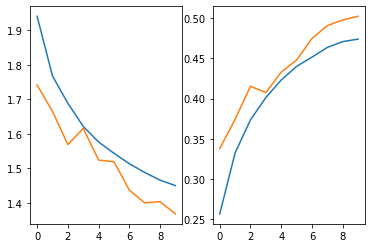

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

## 이미지 파일

In [2]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/공부/archi.zip'

In [3]:
train_folder = '/content/cifar10/train'
test_folder = '/content/cifar10/test'
train_path = sorted(glob.glob(train_folder+'/*/*')) # 파일 경로 리스트
test_path = sorted(glob.glob(test_folder+'/*/*'))

In [8]:
def label_make(path): # 파일명에서 라벨 추출(폴더별로 파일이 나눠져 있음)
    label = []
    for i in path:
        label.append(i.split('/')[-2])
    return label
train_label = label_make(train_path)
test_label = label_make(test_path)

In [5]:
train_label = pd.get_dummies(train_label) # 원핫인코딩
test_label = pd.get_dummies(test_label)

In [ ]:
train_path, validation_path, train_label, validation_label = train_test_split(train_path, train_label, stratify=train_label, test_size=0.1) # 훈련, 검증셋 분리
len(train_path), len(validation_path), len(train_label), len(validation_label)

(45000, 5000, 45000, 5000)

In [10]:
transformer = A.Compose([A.HorizontalFlip(), # 데이터 증가
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

img_size = 30 # 변경 이미지 사이즈(원본 32)

def make_image(path, label=None): # 이미지 경로에서 파일 블러와 텐서로 변경(png)
    image = tf.io.decode_png(tf.io.read_file(path))
    return image, label

def rescale_resize(image, label=None): # 이미지 정규화, 사이즈 조정
    image = tf.cast(image/255, tf.float32)
    image = tf.image.resize(image, size=((img_size, img_size)))
    return image, label

def argument(image, label): # 이미지 증가(리사이즈 동시 진행)
    image = transformer(image=image)['image']
    image, label = rescale_resize(image, label)
    return image, label

def num_fuc(image, label): #  이미지 넘파이 함수 텐서플로우 함수로 계산
    image, label = tf.numpy_function(func=argument, inp=[image, label], Tout=[tf.float32, tf.uint8])
    image.set_shape((img_size, img_size, 3)) # 출력되는 모양 재정의
    label.set_shape((10,))
    return image, label

def make_dataset(path, label=None, train=False): # 데이터 메이커(훈련, 검증, 테스트)
    if label is not None : # 테스트 데이터인지 확인
        dataset = tf.data.Dataset.from_tensor_slices((path, label))
        dataset = dataset.map(make_image)
    else :
        dataset = tf.data.Dataset.from_tensor_slices((path))
        dataset = dataset.map(make_image)

    if train: # 훈련용 데이터 인지 확인
        dataset = dataset.map(num_fuc, num_parallel_calls=autotune).shuffle(1024).batch(32).prefetch(buffer_size=autotune)
    else :
        dataset = dataset.map(rescale_resize, num_parallel_calls=autotune).batch(32).prefetch(buffer_size=autotune)

    return dataset

In [ ]:
train_ds = make_dataset(train_path, train_label, True)
validation_ds = make_dataset(validation_path, validation_label, False)
test_ds = make_dataset(test_path, train = False)

In [12]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0     

In [13]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1140/1140 [==============================] - 91s 78ms/step - loss: 1.9521 - accuracy: 0.2559 - val_loss: 1.7960 - val_accuracy: 0.3314
Epoch 2/10
1140/1140 [==============================] - 87s 76ms/step - loss: 1.7711 - accuracy: 0.3337 - val_loss: 1.9094 - val_accuracy: 0.2837
Epoch 3/10
1140/1140 [==============================] - 86s 75ms/step - loss: 1.6911 - accuracy: 0.3729 - val_loss: 1.5957 - val_accuracy: 0.4277
Epoch 4/10
1140/1140 [==============================] - 87s 76ms/step - loss: 1.6267 - accuracy: 0.4005 - val_loss: 1.5390 - val_accuracy: 0.4467
Epoch 5/10
1140/1140 [==============================] - 86s 74ms/step - loss: 1.5815 - accuracy: 0.4230 - val_loss: 1.5275 - val_accuracy: 0.4474
Epoch 6/10
1140/1140 [==============================] - 86s 75ms/step - loss: 1.5505 - accuracy: 0.4354 - val_loss: 1.4523 - val_accuracy: 0.4664
Epoch 7/10
1140/1140 [==============================] - 86s 75ms/step - loss: 1.5221 - accuracy: 0.4475 - val_loss: 1.4061 -

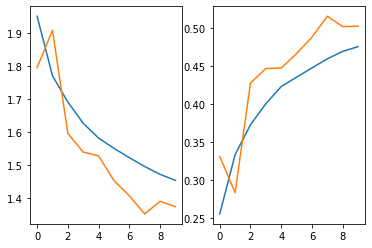

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

StratifiedKFold 사용

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [18]:
epochs = 20
skf = StratifiedKFold(100, shuffle=True) # kfold
train_path, train_label = shuffle(train_path, train_label) # shuffle
skf_li = list(skf.split(train_path, train_label)) # kfold 실행결과 리스트
train_df = pd.DataFrame({'path':train_path, 'label':train_label}) # 데이터 프레임화

for epoch in range(epochs): # 훈련
    print(f'{epoch+1}/{epochs}')
    i, j = skf_li[epoch] # kfold 인덱스 반환
    train_path_x = train_df['path'][i].values # 훈련 데이터 프레임
    train_label_x = pd.get_dummies(train_df['label'][i].values)
    validation_path_x = train_df['path'][j].values # 검증 데이터 프레임
    validation_label_x = pd.get_dummies(train_df['label'][j].values) 
    train_ds = make_dataset(train_path_x, train_label_x, True) # 데이터셋 만들기
    validation_ds = make_dataset(validation_path_x, validation_label_x, False)
    his = model.fit(train_ds, epochs=1, validation_data=validation_ds) # 훈련

1/20
1547/1547 [==============================] - 88s 57ms/step - loss: 2.2255 - accuracy: 0.1579 - val_loss: 1.8637 - val_accuracy: 0.2900
2/20
1547/1547 [==============================] - 86s 55ms/step - loss: 1.8009 - accuracy: 0.3165 - val_loss: 1.6712 - val_accuracy: 0.3380
3/20
1547/1547 [==============================] - 87s 55ms/step - loss: 1.7007 - accuracy: 0.3674 - val_loss: 1.6154 - val_accuracy: 0.3800
4/20
1547/1547 [==============================] - 86s 55ms/step - loss: 1.6286 - accuracy: 0.4045 - val_loss: 1.5158 - val_accuracy: 0.4260
5/20
1547/1547 [==============================] - 88s 57ms/step - loss: 1.5707 - accuracy: 0.4279 - val_loss: 1.5424 - val_accuracy: 0.4440
6/20
1547/1547 [==============================] - 88s 57ms/step - loss: 1.5403 - accuracy: 0.4408 - val_loss: 1.3839 - val_accuracy: 0.4960
7/20
1547/1547 [==============================] - 93s 60ms/step - loss: 1.5023 - accuracy: 0.4550 - val_loss: 1.3391 - val_accuracy: 0.5260
8/20
1547/1547 [====

In [ ]:
tf.keras.utils.image_dataset_from_directory

# tf.keras.utils.image_dataset_from_directory 사용

In [27]:
train_path = '/content/cifar10/train'
test_path = '/content/cifar10/test'

In [32]:
image_size = 30
train_ds = tf.keras.utils.image_dataset_from_directory(train_path, # 폴더별로 나눠저 있는 폴더 위치
                                                       image_size = (image_size, image_size), 
                                                       shuffle = True, # 훈련 데이터, 검증 데이터만 셔플 
                                                       batch_size = 32,
                                                       seed = 42, # shfuffle시 필수
                                                       subset = 'training',# 훈련 데이터
                                                       validation_split = 0.1) # 검증 데이터 비율
validation_ds = tf.keras.utils.image_dataset_from_directory(train_path,
                                                       image_size = (image_size, image_size),
                                                       shuffle = True,
                                                       batch_size = 32,
                                                       seed = 42,
                                                       subset = 'validation', # 검증 데이터
                                                       validation_split = 0.1)

Found 50000 files belonging to 10 classes.
Using 45000 files for training.
Found 50000 files belonging to 10 classes.
Using 5000 files for validation.


In [33]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_path,
                                                      image_size=(image_size,image_size),
                                                      shuffle=False, # 테스트 데이터 shuffle False
                                                      batch_size = 32,)

Found 10000 files belonging to 10 classes.


In [34]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 64)               0   

In [37]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [38]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 54s 38ms/step - loss: 1.8890 - accuracy: 0.3370 - val_loss: 1.5414 - val_accuracy: 0.4222
Epoch 2/10
1407/1407 [==============================] - 54s 39ms/step - loss: 1.5093 - accuracy: 0.4474 - val_loss: 1.4121 - val_accuracy: 0.4740
Epoch 3/10
1407/1407 [==============================] - 51s 36ms/step - loss: 1.3698 - accuracy: 0.5058 - val_loss: 1.2918 - val_accuracy: 0.5338
Epoch 4/10
1407/1407 [==============================] - 54s 39ms/step - loss: 1.2963 - accuracy: 0.5355 - val_loss: 1.2827 - val_accuracy: 0.5432
Epoch 5/10
1407/1407 [==============================] - 54s 38ms/step - loss: 1.2340 - accuracy: 0.5610 - val_loss: 1.2607 - val_accuracy: 0.5524
Epoch 6/10
1407/1407 [==============================] - 55s 39ms/step - loss: 1.1843 - accuracy: 0.5773 - val_loss: 1.1893 - val_accuracy: 0.5780
Epoch 7/10
1407/1407 [==============================] - 55s 39ms/step - loss: 1.1438 - accuracy: 0.5956 - val_loss: 1.1144 -

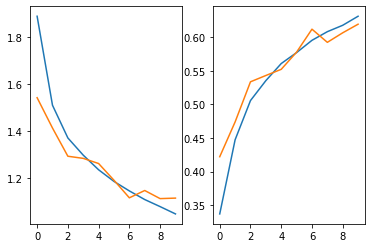

In [39]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

데이터 증강 

In [42]:
inputs = layers.Input(shape=(30,30,3))
x = layers.experimental.preprocessing.RandomFlip('horizontal')(inputs) # 데이터 증강 레이어1
x = layers.experimental.preprocessing.RandomRotation(0.1)(x) # 데이터 증강 레이어2
x = layers.experimental.preprocessing.RandomContrast(0.1)(x) # 데이터 증강 레이어3
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_2   (None, 64)               0   

In [43]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [44]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 53s 37ms/step - loss: 1.8592 - accuracy: 0.3549 - val_loss: 1.5201 - val_accuracy: 0.4214
Epoch 2/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.4592 - accuracy: 0.4708 - val_loss: 1.4459 - val_accuracy: 0.4696
Epoch 3/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.3535 - accuracy: 0.5152 - val_loss: 1.3552 - val_accuracy: 0.5136
Epoch 4/10
1407/1407 [==============================] - 51s 37ms/step - loss: 1.2796 - accuracy: 0.5440 - val_loss: 1.2096 - val_accuracy: 0.5734
Epoch 5/10
1407/1407 [==============================] - 54s 38ms/step - loss: 1.2218 - accuracy: 0.5685 - val_loss: 1.2815 - val_accuracy: 0.5422
Epoch 6/10
1407/1407 [==============================] - 53s 38ms/step - loss: 1.1765 - accuracy: 0.5830 - val_loss: 1.2277 - val_accuracy: 0.5698
Epoch 7/10
1407/1407 [==============================] - 57s 40ms/step - loss: 1.1337 - accuracy: 0.5994 - val_loss: 1.2279 -

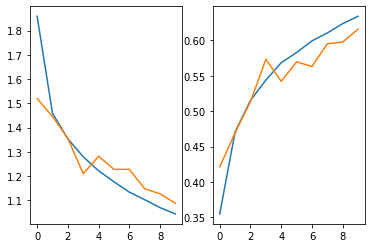

In [45]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

# tensorflow.keras.utils.Sequence  사용

In [247]:
train_folder = '/content/cifar10/train'
test_folder = '/content/cifar10/test'
train_path = sorted(glob.glob(train_folder+'/*/*')) # 파일 경로 리스트
test_path = sorted(glob.glob(test_folder+'/*/*'))

In [248]:
def label_make(path): # 파일명에서 라벨 추출(폴더별로 파일이 나눠져 있음)
    label = []
    for i in path:
        label.append(i.split('/')[-2])
    return label
train_label = label_make(train_path)
test_label = label_make(test_path)

In [249]:
train_path, validation_path, train_label, validation_label = train_test_split(train_path, train_label, test_size=0.1, stratify=train_label)

In [270]:
transformer = A.Compose([A.HorizontalFlip(), # 데이터 증가
                         A.ShiftScaleRotate(),
                         A.RandomBrightnessContrast(),
                         A.RandomFog(),
                         A.Rotate(20)
                         ])

def argument(image):
    image = transformer(image=image)['image']
    return image

class data_make(tf.keras.utils.Sequence):
    def __init__(self, path, label=None, batch_size = 32, image_size=32, train=False, shuffle=False):
        self.path = path
        self.batch_size = batch_size 
        self.image_size = image_size
        self.train = train
        self.shuffle = shuffle
        self.on_epoch_end()

        if label is not None:
            self.label = pd.get_dummies(label)

        if self.shuffle :
            self.on_epoch_end()
        else :
            self.indexr = np.arange(len(self.path))

    def __len__(self):
        return int(np.ceil(len(self.path) / self.batch_size))

    def __getitem__(self, index):
        path = []
        for i in self.indexr[index * self.batch_size : (index+1) * self.batch_size]:
            path.append(self.path[i])

        if self.label is not None:
            label = []
            for i in self.indexr[index * self.batch_size : (index+1) * self.batch_size]:
                label.append(self.label.iloc[i].values)

        imgae = np.zeros((len(path), self.image_size, self.image_size, 3), dtype=np.float32)
        for i in range(len(path)):
            img = cv2.imread(path[i])
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))
            if self.train:
                img = argument(img)
            img = tf.cast(img/255, dtype = tf.float32)
            imgae[i] = img
            image = tf.cast(imgae, tf.float32)
            image.set_shape((len(path), self.image_size, self.image_size, 3))

        return image, np.array(label)

    def on_epoch_end(self):
        self.indexr = np.arange(len(self.path))
        if self.shuffle:
            np.random.shuffle(self.indexr)

In [271]:
train_ds = data_make(train_path, train_label, image_size = 30, train = True, shuffle=True)
validation_ds = data_make(validation_path, validation_label, image_size = 30, train = False, shuffle=False)
test_ds = data_make(test_path, image_size = 30, train = False, shuffle=False)

In [274]:
inputs = layers.Input(shape=(30,30,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(64,activation='relu')(x)
outputs = layers.Dense(10,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_15  (None, 64)               0  

In [275]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [276]:
his = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
1407/1407 [==============================] - 61s 43ms/step - loss: 1.9687 - accuracy: 0.2476 - val_loss: 1.7862 - val_accuracy: 0.3052
Epoch 2/10
1407/1407 [==============================] - 58s 41ms/step - loss: 1.7729 - accuracy: 0.3342 - val_loss: 1.6120 - val_accuracy: 0.4024
Epoch 3/10
1407/1407 [==============================] - 60s 43ms/step - loss: 1.6739 - accuracy: 0.3857 - val_loss: 1.5220 - val_accuracy: 0.4502
Epoch 4/10
1407/1407 [==============================] - 59s 42ms/step - loss: 1.6068 - accuracy: 0.4144 - val_loss: 1.4600 - val_accuracy: 0.4666
Epoch 5/10
1407/1407 [==============================] - 58s 41ms/step - loss: 1.5604 - accuracy: 0.4306 - val_loss: 1.4399 - val_accuracy: 0.4756
Epoch 6/10
1407/1407 [==============================] - 59s 42ms/step - loss: 1.5240 - accuracy: 0.4459 - val_loss: 1.4155 - val_accuracy: 0.4904
Epoch 7/10
1407/1407 [==============================] - 58s 41ms/step - loss: 1.4981 - accuracy: 0.4590 - val_loss: 1.3979 -

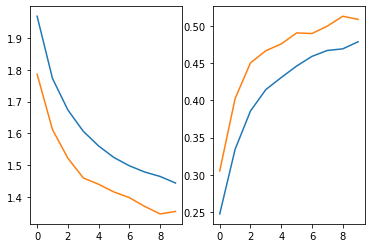

In [277]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()